In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d

In [2]:
# used data
df = pd.read_csv('10_days_minute.csv')
df_open = df['open'].values[::-1] # to old->new
arr = df_open[6500: 7500]
df = pd.DataFrame(arr)

In [3]:
def closest_pair(arr):
    return np.amin(np.diff(arr))

def select_local_extremes_dist(extremes, extreme_values, threshold, function):
    while closest_pair(extremes) < threshold:
        new_extremes = argrelextrema(extreme_values, function, mode='wrap')[0]
        extremes = extremes[new_extremes]
        extreme_values = extreme_values[new_extremes]
    return extremes

def select_local_extremes_it(arr, it_count):
    maxima = np.arange(arr.size)
    maxima_values = arr
    
    minima = np.arange(arr.size)
    minima_values = arr

    for _ in range(it_count):
        new_maxima = argrelextrema(maxima_values, np.greater, mode='wrap')[0]
        maxima = maxima[new_maxima]
        maxima_values = maxima_values[new_maxima]

        new_minima = argrelextrema(minima_values, np.less, mode='wrap')[0]
        minima = minima[new_minima]
        minima_values = minima_values[new_minima]

    last = arr.size - 1
    minima = np.insert(minima, 0, 0)
    maxima = np.insert(maxima, 0, 0)
    minima = np.insert(minima, minima.size, last)
    maxima = np.insert(maxima, maxima.size, last)
    
    return minima, maxima

def clean_zigzag(minima, maxima):
    min_pairs = create_pairs(minima)
    max_pairs = create_pairs(maxima)

    for pair in min_pairs:
        elements = np.where((maxima >= pair[0]) & (maxima <= pair[1]))[0]
        if elements.size > 1:
            elements_values = arr[maxima[elements]]
            max_element = np.argmax(elements_values)
            elements = np.delete(elements, max_element)
            maxima = np.delete(maxima, elements)

    for pair in max_pairs:
        elements = np.where((minima >= pair[0]) & (minima <= pair[1]))[0]
        if elements.size > 1:
            elements_values = arr[minima[elements]]
            min_element = np.argmin(elements_values)
            elements = np.delete(elements, min_element)
            minima = np.delete(minima, elements)
    return minima, maxima

def fill_edges(minima, maxima):
    last = arr.size - 1
    minima = np.insert(minima, 0, 0)
    maxima = np.insert(maxima, 0, 0)
    minima = np.insert(minima, minima.size, last)
    maxima = np.insert(maxima, maxima.size, last)
    return minima, maxima

def plot(df, minima, maxima):
    
    x_min = minima
    y_min = arr[x_min]
    x_max = maxima
    y_max = arr[x_max]

    plt.figure(figsize=(30, 10))
    plt.title('BTC')
    plt.xlabel('minute')
    plt.ylabel('Value')
    plt.plot(pd.DataFrame(df))

    plt.scatter(x_max,y_max,s=70,color='green',zorder=2)
    plt.scatter(x_min,y_min,s=70,color='red',zorder=2)

    plt.show()

def create_pairs(arr):
    a = arr[:-1]
    b = arr[1:]
    return np.stack((a, b), axis=-1)

def find_minmax_in_range(range, arr, func):
    interval = arr[np.arange(start = range[0], stop=range[1])]
    interval_minmax = func(interval)
    return range[0] + interval_minmax

def fix_zigzag_min(minima, maxima, interval, arr, min_arg):
    a = arr[interval[0]]
    b = arr[interval[1]]
    local_min = arr[min_arg]
    if local_min >= a or local_min >= b:
        if a < b:
            # print(f'deleting from maxima interval position {interval[0]} with value {a}')
            maxima = np.delete(maxima, np.where(maxima == interval[0]))
        else:
            # print(f'deleting from maxima interval position {interval[1]} with value {b}')
            maxima = np.delete(maxima, np.where(maxima == interval[1]))
    else:
        # print(f'appending to minima position {min_arg} with value {local_min}')
        minima = np.append(minima, min_arg)
    return minima, maxima

def fix_zigzag_max(minima, maxima, interval, arr, max_arg):
    a = arr[interval[0]]
    b = arr[interval[1]]
    local_max = arr[max_arg]
    if local_max <= a or local_max <= b:
        if a > b:
            # print(f'deleting from minima interval position {interval[0]} with value {a}')
            minima = np.delete(minima, np.where(minima == interval[0]))
        else:
            # print(f'deleting from minima interval position {interval[1]} with value {b}')
            minima = np.delete(minima, np.where(minima == interval[1]))
    else:
        # print(f'appending to maxima position {max_arg} with value {local_max}')
        maxima = np.append(maxima, max_arg)
    return minima, maxima

In [4]:
def maxmin_1():
    maxima = argrelextrema(arr, np.greater, mode='wrap')[0]
    maxima_values = arr[maxima]

    minima = argrelextrema(arr, np.less, mode='wrap')[0]
    minima_values = arr[minima]

    maxima = select_local_extremes_dist(maxima, maxima_values, 10, np.greater)
    minima = select_local_extremes_dist(minima, minima_values, 10, np.less)
    
    minima, maxima = clean_zigzag(minima, maxima)

    plot(df, minima, maxima)

    return minima, maxima

In [5]:
def maxmin_2():
    maxima = argrelextrema(arr, np.greater, mode='wrap')[0]
    maxima_values = arr[maxima]

    minima = argrelextrema(arr, np.less, mode='wrap')[0]
    minima_values = arr[minima]

    maxima = select_local_extremes_dist(maxima, maxima_values, 10, np.greater)
    minima = select_local_extremes_dist(minima, minima_values, 10, np.less)
    
    minima, maxima = clean_zigzag(minima, maxima)

    for range in create_pairs(maxima):
        elements = np.where((minima > range[0]) & (minima < range[1]))[0]
        if len(elements) == 0:
            new_argmin = find_minmax_in_range((range[0]+1, range[1]), arr, np.argmin)
            minima, maxima = fix_zigzag_min(minima, maxima, range, arr, new_argmin)

    minima = np.sort(minima)
    maxima = np.sort(maxima)

    for range in create_pairs(minima):
       elements = np.where((maxima > range[0]) & (maxima < range[1]))[0]
       if len(elements) == 0:
           new_argmax = find_minmax_in_range((range[0]+1, range[1]), arr, np.argmax)
           minima, maxima = fix_zigzag_max(minima, maxima, range, arr, new_argmax)

    minima = np.sort(minima)
    maxima = np.sort(maxima)
    
    minima, maxima = clean_zigzag(minima, maxima)

    plot(df, minima, maxima)

    return minima, maxima

In [6]:
def maxmin_3():
    # pick local extrema and in cycle (3) pick local extremes of local extremes - separately for minima and maxima
    minima, maxima = select_local_extremes_it(arr, 3)
    
    # remove local extrema so that minima is always followed by maxima and vice versa
    minima, maxima = clean_zigzag(minima, maxima)

    plot(df, minima, maxima)

    return minima, maxima

In [7]:
def maxmin_4():
    x = arr
    # select local extremes with given parameters - hand-picked data used as parameter tuning reference
    maxima, _ = find_peaks( x, width=5, threshold=6, prominence=70, distance=18)
    minima, _ = find_peaks(-x, width=5, threshold=6, prominence=70, distance=18)

    # place points at the beginning and end of local extrema array
    minima, maxima = fill_edges(minima, maxima)
    # remove local extrema so that minima is always followed by maxima and vice versa
    minima, maxima = clean_zigzag(minima, maxima)

    plot(df, minima, maxima)
    
    return minima, maxima

In [8]:
def maxmin_5():
    # like running average. does not create fake local extrema
    gaussian_array = gaussian_filter1d(arr, 9)

    # get local extrema of gaussian array
    minima, maxima = select_local_extremes_it(gaussian_array, 1)
    minima, maxima = clean_zigzag(minima, maxima)

    min_pairs = create_pairs(minima)
    max_pairs = create_pairs(maxima)

    # find max between two local minima and vice versa
    maxima = [find_minmax_in_range((pair[0]+1, pair[1]), arr, np.argmax) for pair in min_pairs]
    minima = [find_minmax_in_range((pair[0]+1, pair[1]), arr, np.argmin) for pair in max_pairs]

    # add points at the end and beginning of array
    minima, maxima = fill_edges(minima, maxima)
    minima, maxima = clean_zigzag(minima, maxima)

    plot(df, minima, maxima)

    return minima, maxima

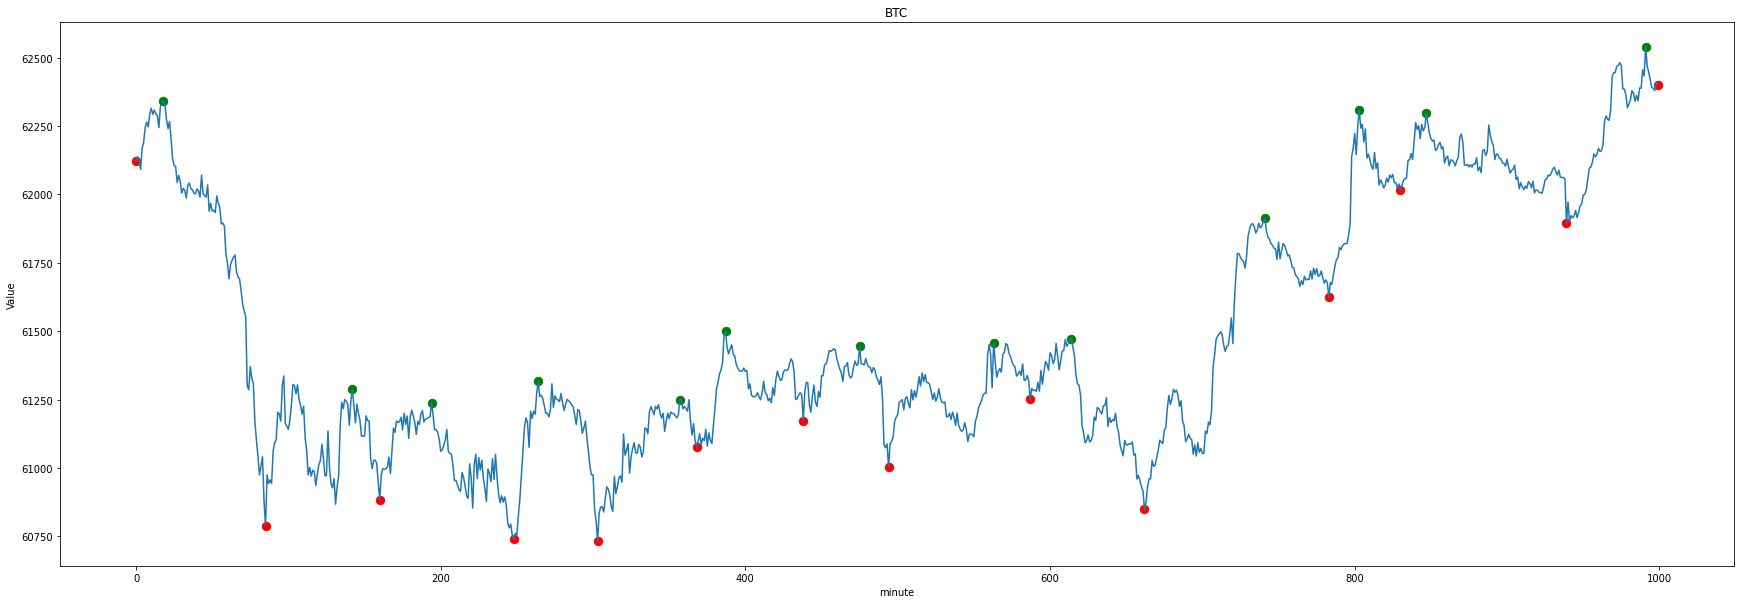

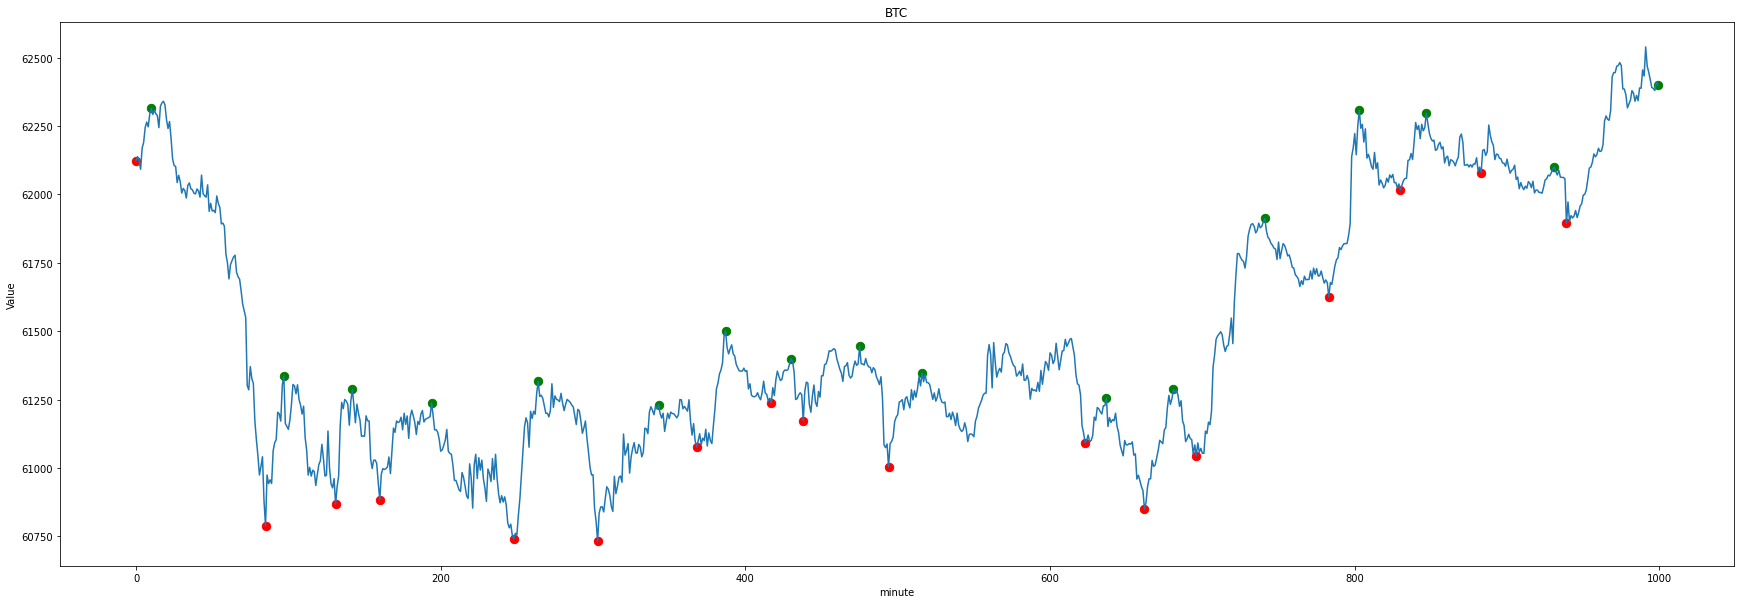

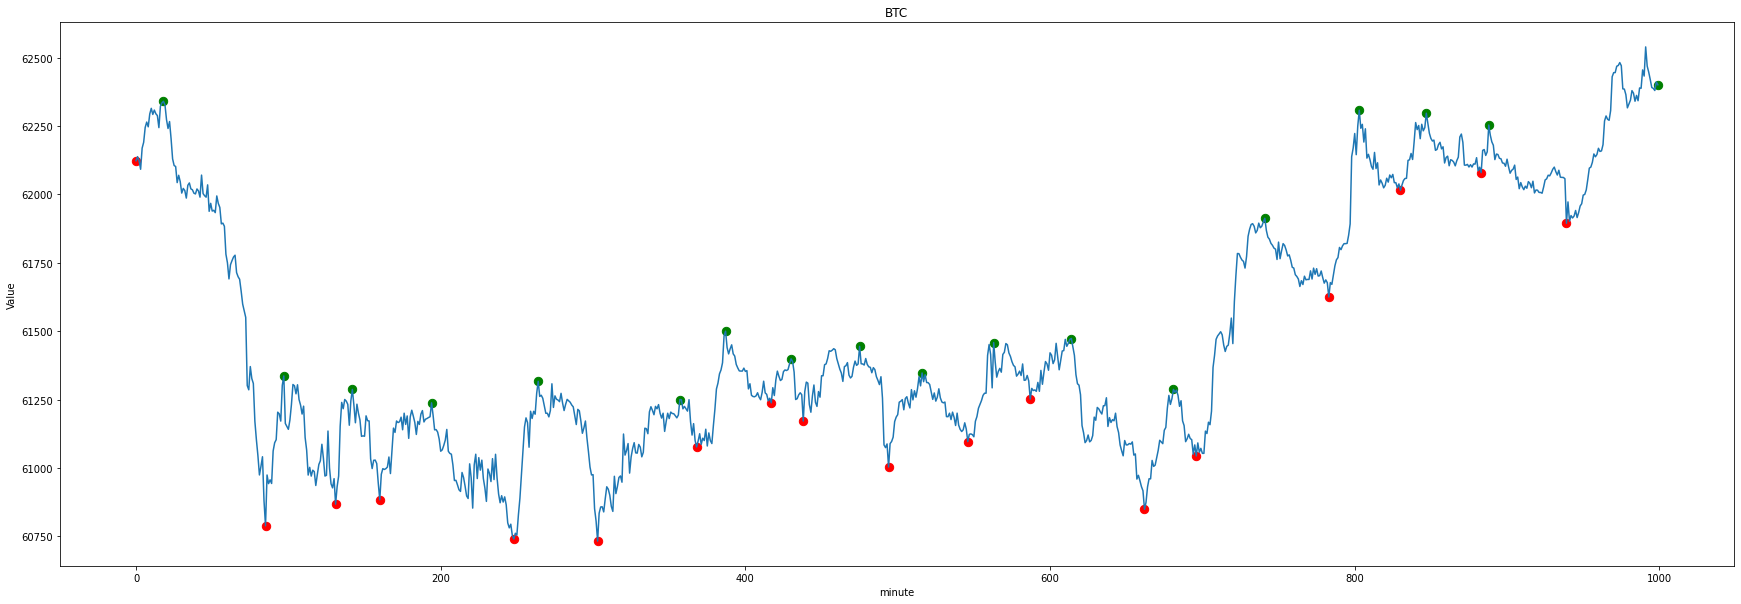

In [9]:
minima, maxima = maxmin_3()
minima, maxima = maxmin_4()
minima, maxima = maxmin_5()